In [2039]:
import os
import pandas as pd
import numpy as np
import numpy.linalg as la
from numpy.random import uniform, normal
import matplotlib.pyplot as plt
import itertools
plt.rcParams.update({'font.size': 15})

### References

[fast fourier transform](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html)

[polynomials](https://numpy.org/doc/stable/reference/generated/numpy.poly.html)

[complex exponentials](https://www.princeton.edu/~wbialek/intsci_web/dynamics2.2.pdf)

[Eigenvalues & Unit Roots](https://econweb.ucsd.edu/muendler/teach/gen/diffeqn.pdf)

# VAR Models
https://www.asc.ohio-state.edu/de-jong.8/note6.pdf

In [2134]:
class VARMA:
    """
    d:= Number of Series
    p:= AR(p) model
    q:= MA(q) model
    N:= Length of Series
    """
    def __init__(self, d, p, q, N):
        self.d = d
        self.p = p
        self.q = q
        self.N = N
        self.PHI = None
        self.THETA = None
              
    def generate_coefs(self, c_range, k):
        """  
        c_range:= (float) coef range
        arma_type = (string) 'ar' or 'ma' not case sensitive
        k:= (int) either p or q value of d-dimensional VARMA(p,q)
        
        returns coefficient matrix of an arbitrary stationary process
        """ 
        d = self.d
        Matr = np.zeros(shape = (k*d, k*d))
        root_test = False
        while root_test != True:

            # creating k (dxd) coef matricies with random coefs
            coefs = np.array([uniform(-c_range, c_range, size = (d,d)) for i in range(k)])
            coefs[abs(coefs) < 0.1] = 0

            # creating pd-dimesnional Var(1) coef matrix 
            Matr[:d, :k*d] = np.concatenate(coefs, axis = 1)
            Matr[d:k*d, :-d] = np.identity((k-1)*(d))
            
            # testing if all roots z are s.t. |z| > 1
            eigen_vals = la.eig(Matr)[0]           
            root_test = all(list(map(lambda x: np.abs(x) < 1, eigen_vals)))
        
        # flipping sign of ar coefficients
  
        return Matr
        
    def simulate(self):
        d, p, q, N = self.d, self.p, self.q, self.N
        pq_max = max([p,q])
        coef_range = 2
        
        # generating VARMA coeffs and creating lambda functions
        if p > 0:
            PHI = self.generate_coefs(coef_range, p)[:d]
            self.PHI = PHI
            ar = lambda x: PHI@np.concatenate(x)
        else:
            ar = lambda x: np.zeros(shape = (d,1))
        if q > 0:
            THETA = self.generate_coefs(coef_range, q)[:d]
            self.THETA = THETA
            ma = lambda x: THETA@np.concatenate(x)
        else:
            ma = lambda x: np.zeros(shape = (d,1))
        
        # propogating VARMA model
        std_x, std_e = 1, 1
        x = [normal(0, std_x, size = (d,1)) for i in range(pq_max)]
        e = [normal(0, std_e, size = (d,1)) for i in range(pq_max)]
        for _ in range(N):
            error_t = normal(0, std_e, size = (d,1))
            X_t = ar(x[:-p-1:-1]) + ma(e[:-q-1:-1]) + error_t
            e.append(error_t)
            x.append(X_t)
              
        # storing series in dataframe
        x = np.array(x)[pq_max:]
        df = pd.DataFrame(x[:,:,0], columns = ['x{}'.format(i) for i in range(1,d+1)])
        return df

In [2156]:
d = 3
p = 2
q = 0
N = 200

V = VARMA(d, p, q, N)
df = V.simulate()

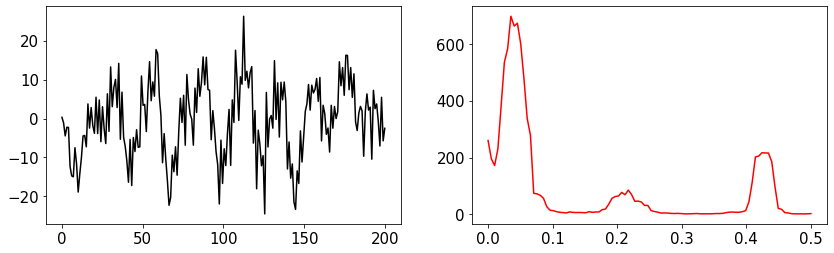

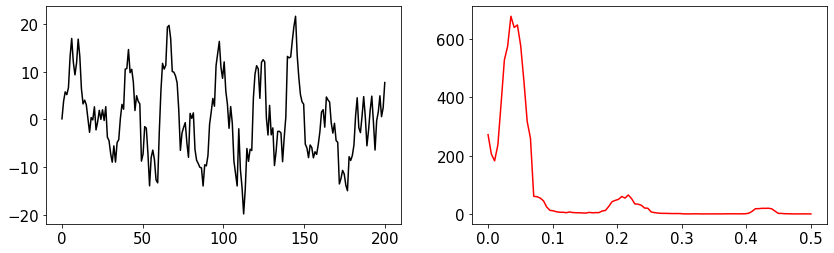

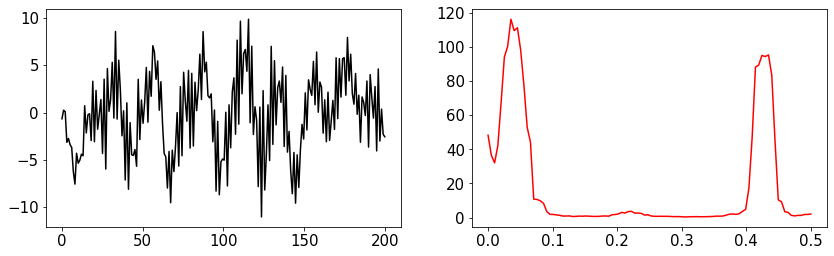

In [2157]:
for col in df.columns:
    
    X_t = df[col].values
    F = fourier(X_t)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize = (14,4))
    ax0.plot(np.linspace(0,N,N), X_t, color = 'k')
    ax1.plot(F.f_freqs, F.spectral_density(3), color = 'r')
    plt.show()

# Spectral Methods

In [2158]:
class spectral_ts:
    """
    tools for spectral analysis of multivariate time series
    """
    def __init__(self, raw_data, m):
        
        # data keys/attributes
        self.N, self.d = raw_data.shape
        
        # fourier frequencies and band init
        self.f_freqs = np.linspace(0, .5, int(.5/(1/self.N)))
        self.L = 2*m+1 
        self.band = np.linspace(-m/self.N, m/self.N, self.L)
        
        # data
        self.mu_list = raw_data.mean()
        self.data = (raw_data-self.mu_list).to_numpy()
        self.AC_matrix = self.make_auto_cov()
        self.SD_matrix = self.make_spec_density()
        self.SQRC_matrix = self.make_squared_coherence()
        
    def acov(self, h):
        # autocovariance matrix at lag h
        if h == 0:
            return np.cov(self.data.T, ddof=0)
        else:
            return (self.data[h:].T@self.data[:-h])/self.N
    
    def make_auto_cov(self):
        # generates (N,d,d) matrix containing acov for each lag
        return np.array([self.acov(h) for h in range(self.N)])
        
    def dft(self, w):
        # discrete fourier transform of autocovariance matrix at freq w
        cos = sum([self.AC_matrix[t]*np.cos(2*np.pi*w*t) for t in range(self.N)])
        sin = sum([self.AC_matrix[t]*np.sin(2*np.pi*w*t) for t in range(self.N)])
        return np.matrix(self.N**(-1/2)*(cos-sin*(1j)))
    
    def periodogram(self, w):
        # averaging over frequency band with size L = 2*m+1
        I = np.zeros(shape = (self.d, self.d))
        for m_n in self.band:
            X_dft = self.dft(w+m_n)
            I += (X_dft@X_dft.H).real
        return I/self.L
    
    def make_spec_density(self):
        # generates a (d,d) coherency matrix for each fourier frequency
        return np.array([self.periodogram(w) for w in self.f_freqs])
    
    def make_squared_coherence(self):
        # normalized coherency matrix
        SQC_matrix = np.zeros(shape = (self.SD_matrix.shape[0],self.d, self.d))
        for i in range(self.d):
            for j in range(self.d):
                c_ij = self.SD_matrix[:,i,j]
                c_ii = self.SD_matrix[:,i,i]
                c_jj = self.SD_matrix[:,j,j]
                SQC_matrix[:,i,j] = abs(c_ij)**2/(c_ii*c_jj)
        return SQC_matrix

In [2159]:
m = 3 # frequency band length L = 2*m+1
SPECTRAL = spectral_ts(df, m)

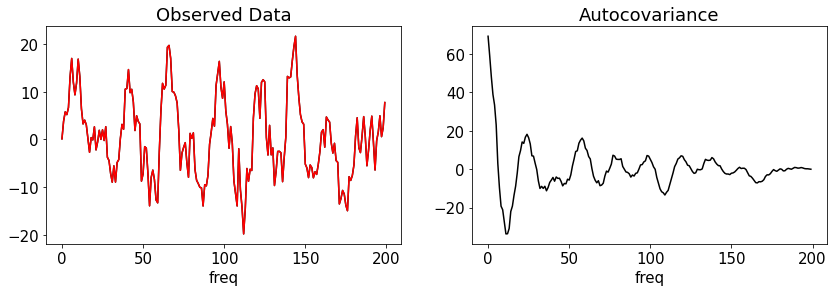

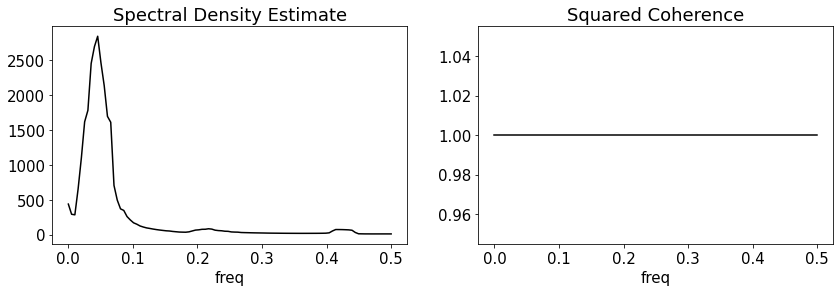

In [2160]:
i, j = 1, 1
auto_covariance = SPECTRAL.AC_matrix[:,i,j]
spectral_density = SPECTRAL.SD_matrix[:,i,j]
squared_coherence = SPECTRAL.SQRC_matrix[:,i,j]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14,4))
ax0.plot(df.index, df['x{}'.format(i+1)], color = 'k')
ax0.plot(df.index, df['x{}'.format(j+1)], color = 'r')
ax0.set_title('Observed Data')
ax0.set_xlabel('freq')
ax1.plot(df.index, auto_covariance, color = 'k')
ax1.set_title('Autocovariance')
ax1.set_xlabel('freq')
plt.show()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14,4))
ax0.plot(SPECTRAL.f_freqs, spectral_density, color = 'k')
ax0.set_title('Spectral Density Estimate')
ax0.set_xlabel('freq')
ax1.plot(SPECTRAL.f_freqs, squared_coherence, color = 'k')
ax1.set_title('Squared Coherence')
ax1.set_xlabel('freq')
plt.show()

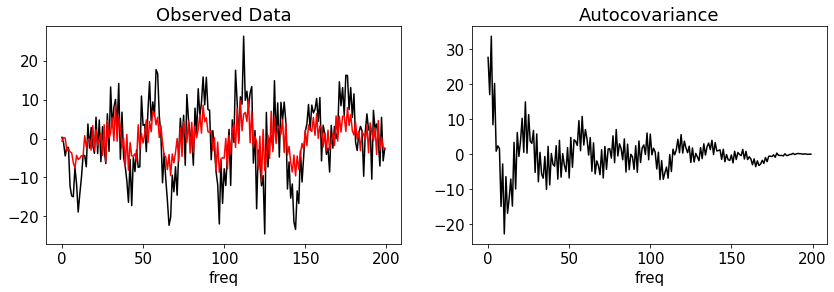

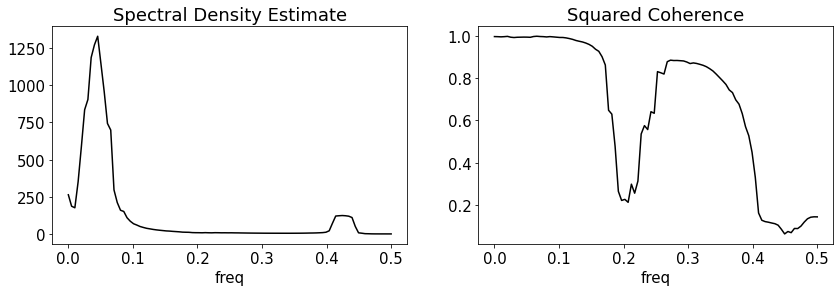

In [2161]:
i, j = 0,2
auto_covariance = SPECTRAL.AC_matrix[:,i,j]
spectral_density = SPECTRAL.SD_matrix[:,i,j]
squared_coherence = SPECTRAL.SQRC_matrix[:,i,j]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14,4))
ax0.plot(df.index, df['x{}'.format(i+1)], color = 'k')
ax0.plot(df.index, df['x{}'.format(j+1)], color = 'r')
ax0.set_title('Observed Data')
ax0.set_xlabel('freq')
ax1.plot(df.index, auto_covariance, color = 'k')
ax1.set_title('Autocovariance')
ax1.set_xlabel('freq')
plt.show()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14,4))
ax0.plot(SPECTRAL.f_freqs, abs(spectral_density), color = 'k')
ax0.set_title('Spectral Density Estimate')
ax0.set_xlabel('freq')
ax1.plot(SPECTRAL.f_freqs, squared_coherence, color = 'k')
ax1.set_title('Squared Coherence')
ax1.set_xlabel('freq')
plt.show()